# A Post Office – A Real Life Story

*Paul Bayer, 2017-09-21, v0.2*

Let us begin with an everyday story: there is a small post office with one clerk serving the arriving customers. Customers have differing wishes leading to different serving times, from `1 - 5 minutes`. We have to add a little variation to serving times counting for variation in customer habits and clerk performance. The arrival rate of customers is about 18 per hour, every `3.33 minutes` or `3 minutes, 20 seconds` on average. Our post office is small and customer patience is limited, so queue length is limited to 5 customers. 

We have provided 10% extra capacity, so our expectation is that there should not be too many customers discouraged for long waiting times or for full queues.

![](pictures/PostOffice.png)

Let's do a simulation in [```Julia```](https://julialang.org) using Julia coroutines. We need 

1. a source: all the **people**, providing an unlimited supply for customers,
2. **customers** with their demands and their limited patience,
3. a **queue** and
4. our good old **clerk**.

In [1]:
using PFlow, Distributions, DataFrames

mutable struct Customer
    id::Int64
    arrival::Float64
    request::Int64

    function Customer(n::Int64, arrival::Float64)
        new(n, arrival, rand(DiscreteUniform(1, 5)))
    end
end

full(q::Channel) = length(q.data) >= q.sz_max

function people(sim::DES, β::Float64, queue::Channel)
    i = 1
    timer = 0.0
    while true
        Δt = rand(Exponential(β))
        delayuntil(sim, timer + Δt)
        timer += Δt
        if !full(queue)
            put!(queue, Customer(i, timer))
            logevent(sim, i, queue, "enqueues", 0)
        else
            logevent(sim, i, queue, "leaves - queue is full!", -1)
        end
        i += 1
    end
end

function clerk(sim::DES, queue::Channel)
    while true
        cust = take!(queue)
        Δt = cust.request + randn()*0.2
        logevent(sim, cust.id, queue, "now being served", sim.time - cust.arrival)
        delay(sim, Δt)
        logevent(sim, cust.id, queue, "leaves", sim.time - cust.arrival)
    end
end

function logevent(sim::DES, customer, queue, status, wt)
    push!(l["time"], sim.time)
    push!(l["cust"], customer)
    push!(l["qlen"], length(queue.data))
    push!(l["status"], status)
    push!(l["wtime"], wt)
end

srand(1234)  # seed random number generator for reproducibility
queue = Channel(5)

sim = DES()
l = Dict("time"=>[], "cust"=>[], "qlen"=>[], "status"=>[], "wtime"=>[])
p = @async people(sim, 3.333, queue)
c = @async clerk(sim, queue)
simulate(sim, 600, finish=false)
d = DataFrame(time=round.(l["time"],2), cust=l["cust"], qlen=l["qlen"], 
            status=l["status"], wtime=round.(l["wtime"],2))
println("$(length(queue.data)) customers yet in queue")

Simulation ends after 194 ms - next event at:600.0 ≥ stime after 969 events
0 customers yet in queue


In [2]:
d

,time,cust,qlen,status,wtime
1,8.28,1,1,enqueues,0.0
2,9.0,1,0,now being served,0.72
3,10.29,2,1,enqueues,0.0
4,10.82,1,1,leaves,2.54
5,10.82,2,0,now being served,0.53
6,12.93,2,0,leaves,2.63
7,19.56,3,1,enqueues,0.0
8,20.0,3,0,now being served,0.44
9,20.9,3,0,leaves,1.34
10,20.95,4,1,enqueues,0.0


In [3]:
tail(d)

,time,cust,qlen,status,wtime
1,589.26,190,2,enqueues,0.0
2,590.21,188,2,leaves,6.69
3,590.21,189,1,now being served,5.73
4,591.28,189,1,leaves,6.8
5,591.28,190,0,now being served,2.02
6,592.22,190,0,leaves,2.95


In [4]:
nrow(d) # number of rows / registered events

542

In [5]:
describe(d[d[:wtime] .> 0, :wtime])

Summary Stats:
Mean:           8.813153
Minimum:        0.040000
1st Quartile:   4.997500
Median:         8.210000
3rd Quartile:   12.625000
Maximum:        25.150000
Length:         352
Type:           Float64
Number Missing: 0
% Missing:      0.000000


In `600` minutes simulation time, we registered `190` customers and `542` events. The mean and median waiting times were slightly above 10 minutes.

In [6]:
by(d, :status, df -> size(df, 1))

,status,x1
1,enqueues,176
2,now being served,176
3,leaves,176
4,leaves - queue is full!,14


Of the `190` customers, `176` participated in the whole process and were served, but `14` left beforehand because the queue was full. 

In [7]:
view(d, d[:wtime] .< 0)

,time,cust,qlen,status,wtime
1,182.11,55,5,leaves - queue is full!,-1.0
2,258.25,77,5,leaves - queue is full!,-1.0
3,264.37,79,5,leaves - queue is full!,-1.0
4,264.87,80,5,leaves - queue is full!,-1.0
5,271.17,83,5,leaves - queue is full!,-1.0
6,376.07,116,5,leaves - queue is full!,-1.0
7,379.93,117,5,leaves - queue is full!,-1.0
8,407.45,127,5,leaves - queue is full!,-1.0
9,431.25,135,5,leaves - queue is full!,-1.0
10,432.66,137,5,leaves - queue is full!,-1.0


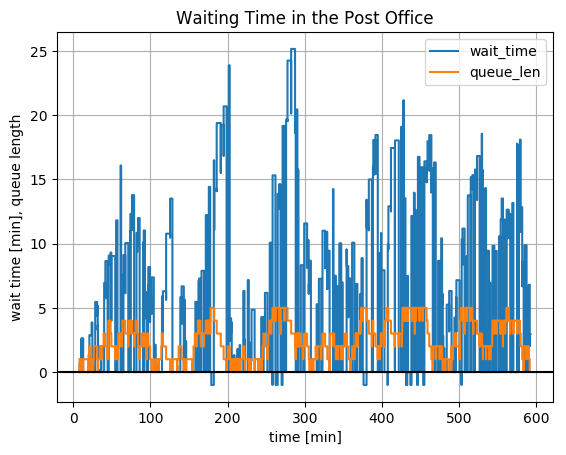

In [8]:
using PyPlot
step(d[:time], d[:wtime])
step(d[:time], d[:qlen])
axhline(y=0, color="k")
grid()
xlabel("time [min]")
ylabel("wait time [min], queue length")
title("Waiting Time in the Post Office")
legend(["wait_time", "queue_len"]);

Many customers had waiting times of more than 10, 15 up to even more than 20 minutes. The negative waiting times were the `14` customers, which left because the queue was full.

So many customers will remain angry. If this is the situation all days, our post office will have an evil reputation. What should we do?

## Conclusion

Even if our process runs within predetermined bounds (queue length, customer wishes …), it seems to fluctuate wildly and to produce unpredicted effects. We see here the **effects of variation** in arrivals, in demands and in serving time on system performance. In this case 10% extra capacity is not enough to provide enough buffer for variation and for customer service – even if our post clerk is the most willing person.

Even for such a simple everyday system, we cannot say beforehand – without reality check – which throughput, waiting times, mean queue length, capacity utilization or customer satisfaction will emerge. Even more so for more complicated systems in production, service, projects and supply chains with multiple dependencies.

If we had known the situation beforehand, we could have provided standby for our clerk or install an automatic stamp dispenser for cutting the short tasks … 

Finally, this is, what this Repository `PFlow` is all about: 

- to **check assumptions about processes by means of simulation** 
- to see what may happen beforehand and 
- to get processes and systems flow before they fail – as in this case – to deliver their expected outcomes. 

It is clear, that it must be **easier** to do than to write programs in Julia and to read and interpret long lists as demonstrated. The objective of this repository is to provide a simple open source framework for such tasks.